<a href="https://colab.research.google.com/github/gracee331/Repo/blob/main/SmartLINE%EF%BC%9A%E7%B5%90%E5%90%88_Gemini_%E5%9B%9E%E6%87%89%E8%88%87_Template_Messages_%E7%9A%84%E6%99%BA%E6%85%A7%E6%A9%9F%E5%99%A8%E4%BA%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 專案背景與動機


# 專案報告: SmartLINE：結合 Gemini 回應與 Template Messages 的智慧機器人

### 專案背景  
隨著生成式 AI 技術的普及，我認為將其整合至日常通訊工具能構成新的趨勢。然而，目前多數 AI 介面門檻仍高。本專案旨在將 Gemini 的智能對話能力整合至廣受歡迎的 LINE 平台，並結合 Reply Template Messages 提供更佳的互動體驗。透過這個專案，希望能降低使用者接觸 AI 的門檻，讓使用者能透過熟悉的 LINE 聊天介面輕鬆與 AI 互動，解決問題或獲取資訊。

### 專案目標  
- 建立一個具備對話能力的 LINE Bot，並可透過 Google Gemini API 回應使用者提問。  
- 開發並應用 Reply Template Messages，提供更豐富且結構化的使用者互動體驗。
- 降低使用者接觸生成式 AI 的門檻，使其能透過熟悉的 LINE 介面進行自然對話。  
- 預期成果為開發一個穩定運行、回應迅速、且能提供智慧與有用的對話服務的 LINE Bot。

## 系統設計與架構



### 系統功能分析  

| 功能項目 | 說明 |
|----------|------|
| LINE 訊息接收 | 透過 Flask Webhook 接收 LINE 平台發送的使用者訊息|
| 文字訊息處理 |	識別並處理使用者發送的文字訊息|
| 歡迎訊息回覆 |	對於特定的啟動指令（如 "start" 或空白訊息）回覆預設的歡迎文字訊息|
| Confirm Template 回覆 |	對於指令 "confirm"，回覆一個包含「是」和「否」選項的確認模板訊息|
| Carousel Template 回覆 | 對於指令 "carousel"，回覆一個包含多個圖文卡片的輪播模板訊息|
| Gemini 智能對話|	對於非特定指令的文字訊息，調用 Google Gemini API 進行智能對話生成回覆|
|文字回應傳送|	將 Gemini 生成的文字回覆或預設的文字回覆傳送給使用者|
| 模板訊息傳送|	傳送 Confirm Template 和 Carousel Template 給使用者|
| 錯誤處理 |	在 Gemini API 調用失敗時，回覆使用者錯誤提示訊息|

### 系統架構圖


### 使用的技術  

| 技術項目 | 說明 |
|----------|------|
| 程式語言 | Python |
| Web 框架 | Flask（建立 webhook） |
|LINE Bot 開發工具|	LINE Messaging API SDK for Python (用於處理 LINE 訊息、Reply Template Messages 的生成與傳送)
| 部署平台 | Versel |
| 生成式 AI API | Google Gemini API（用於文字生成和智能對話） |
| 資料格式 | JSON 處理傳輸與接收資料 |
|環境變數管理 | 使用環境變數儲存敏感資訊 (LINE Channel Access Token, Channel Secret, Google API Key)|

## 專案成果與效益

### 系統程式

requirements.txt

In [ ]:
flask
line-bot-sdk
google-generativeai

NameError: name 'flask' is not defined

vercel.json

In [ ]:
{
  "version": 2,
  "builds": [
    {
      "src": "app.py",
      "use": "@vercel/python"
    }
  ],
  "routes": [
    {
      "src": "/callback",
      "methods": ["POST"],
      "dest": "app.py"
    },
    {
      "src": "/.*",
      "dest": "app.py"
    }
  ]
}

.env 上傳至vercel

app.py

In [ ]:
import os
from flask import Flask, request, abort
import google.generativeai as genai

from linebot.v3 import WebhookHandler
from linebot.v3.exceptions import InvalidSignatureError
from linebot.v3.webhooks import MessageEvent, TextMessageContent
from linebot.v3.messaging import (
    Configuration, ApiClient, MessagingApi,
    ReplyMessageRequest,
    TextMessage,
    TemplateMessage, ConfirmTemplate, MessageAction,
    CarouselTemplate,
    CarouselColumn,
    URIAction
)

app = Flask(__name__)

configuration = Configuration(access_token=os.getenv('LINE_CHANNEL_ACCESS_TOKEN'))
line_handler = WebhookHandler(os.getenv('LINE_CHANNEL_SECRET'))

genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

@app.route("/callback", methods=['POST'])
def callback():
    signature = request.headers['X-Line-Signature']
    body = request.get_data(as_text=True)
    try:
        line_handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)
    return 'OK'


@line_handler.add(MessageEvent, message=TextMessageContent)
def handle_message(event):
    user_text = event.message.text.strip().lower()

    with ApiClient(configuration) as api_client:
        line_bot_api = MessagingApi(api_client)

        if user_text == "start" or user_text == "":
            reply = TextMessage(text="歡迎使用！請輸入 'confirm' 或 'carousel' 或任何話題和我聊聊喔！")

        elif user_text == "confirm":
            reply = TemplateMessage(
                alt_text="這是確認視窗",
                template=ConfirmTemplate(
                    text="你喜歡史迪奇嗎？",
                    actions=[
                        MessageAction(label="是", text="你真棒!"),
                        MessageAction(label="否", text="不!你喜歡史迪奇")
                    ]
                )
            )

        elif user_text == "carousel":
            carousel_template = CarouselTemplate(
                columns=[
                    CarouselColumn(
                        thumbnail_image_url='https://upload.wikimedia.org/wikipedia/zh/4/4b/Big_Hero_6_%28film%29_poster.jpg',
                        title='大英雄天團',
                        text='可愛氣球杯麵主演的日本電影',
                        actions=[
                            URIAction(label='查看詳情', uri='https://www.niusnews.com/=P312ww05'),
                            MessageAction(label="投票", text="我投杯麵一票")
                        ]
                    ),
                    CarouselColumn(
                        thumbnail_image_url='https://upload.wikimedia.org/wikipedia/zh/d/d0/Snow_White_2025_poster.jpg',
                        title='白雪公主',
                        text='童話故事改編電影',
                        actions=[
                            URIAction(label='查看詳情', uri='https://meet.eslite.com/tw/tc/article/202504280001'),
                            MessageAction(label="投票", text="我投白雪公主一票")
                        ]
                    )
                ]
            )
            reply = TemplateMessage(
                alt_text="這是輪播視窗",
                template=carousel_template
            )

        else:
            try:
                model = genai.GenerativeModel("gemini-2.0-flash")
                response = model.generate_content(user_text)
                reply = TextMessage(text=response.text)
            except Exception as e:
                reply = TextMessage(text=f"抱歉，Gemini 回應出錯了：{e}")

        line_bot_api.reply_message(
            ReplyMessageRequest(
                reply_token=event.reply_token,
                messages=[reply]
            )
        )

if __name__ == "__main__":
    app.run()

NameError: name 'app' is not defined

### 系統畫面

Gemini 回應



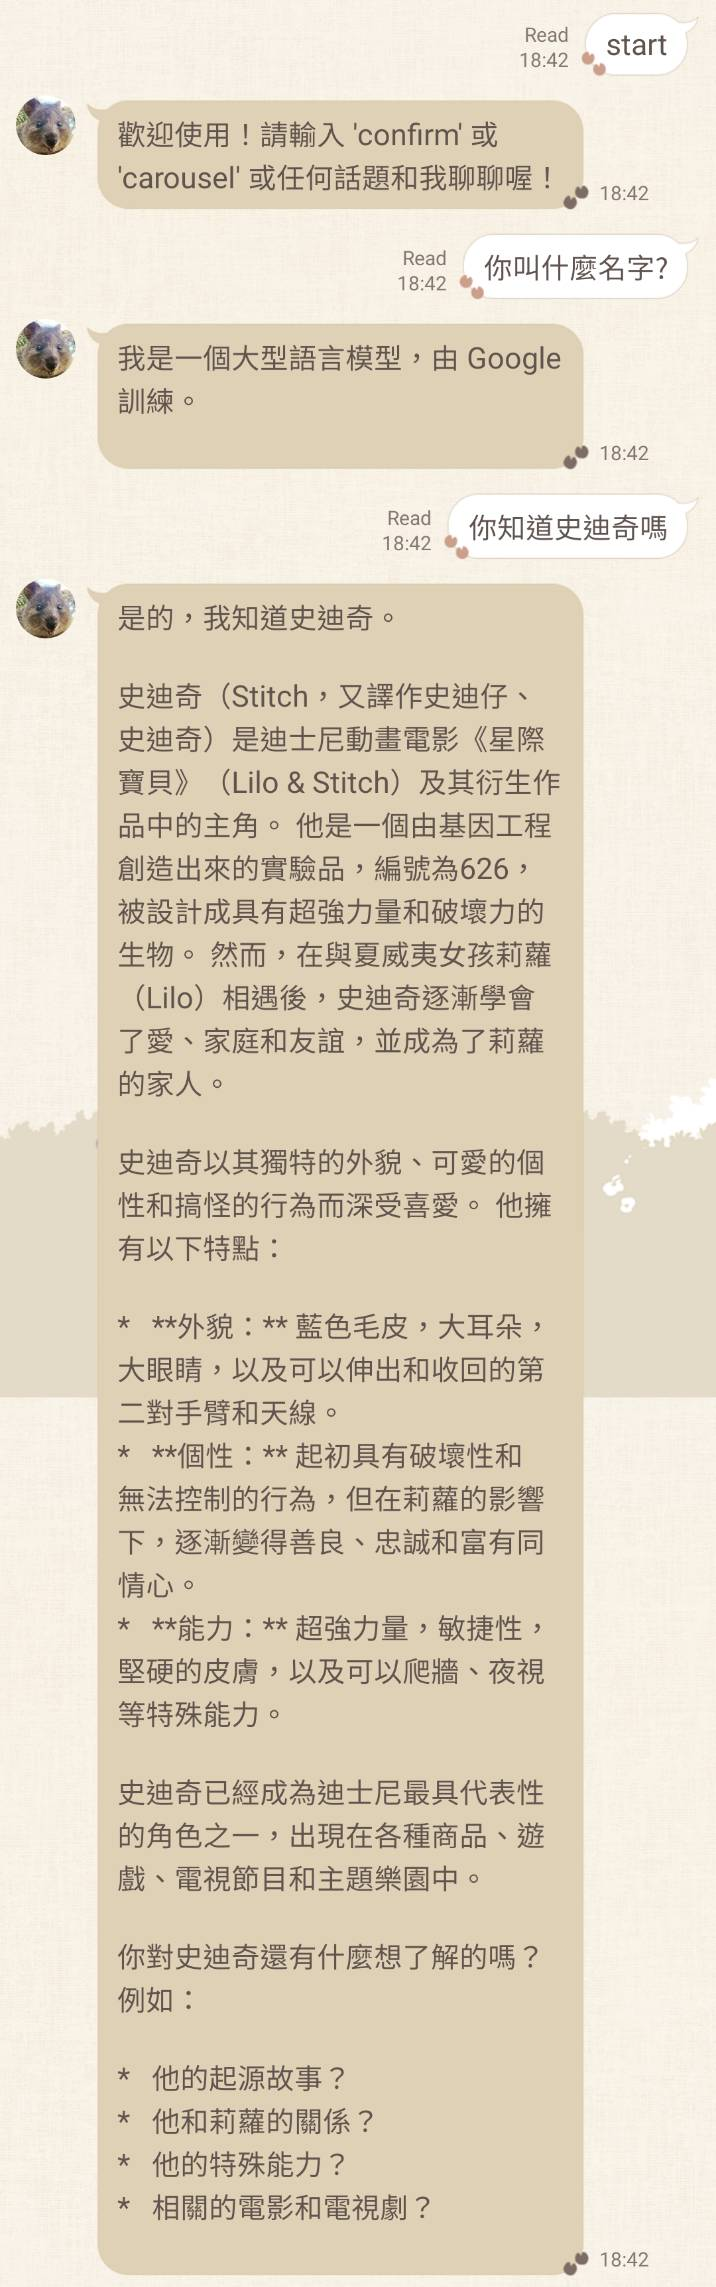

- 使用者於 LINE 傳送訊息：「start」  
- LINE Bot 回應：「歡迎使用！請輸入 'confirm' 或 'carousel' 或任何話題和我聊聊喔！」
- 使用者：「你叫什麼名字?」  
- Bot 回應：「我是一個大型語言模型，由 Google 訓練。」
- 使用者：「你知道史迪奇嗎」  
- Bot 回應：「是的，我知道史迪奇。

    史迪奇（Stitch，又譯作史迪仔、史迪奇）是迪士尼動畫電影《星際寶貝》（Lilo & Stitch）及其衍生作品中的主角。 他是一個由基因工程創造出來的實驗品，編號為626，被設計成具有超強力量和破壞力的生物。 然而，在與夏威夷女孩莉蘿（Lilo）相遇後，史迪奇逐漸學會了愛、家庭和友誼，並成為了莉蘿的家人。

    史迪奇以其獨特的外貌、可愛的個性和搞怪的行為而深受喜愛。 他擁有以下特點...」

Reply Template Messages 回應

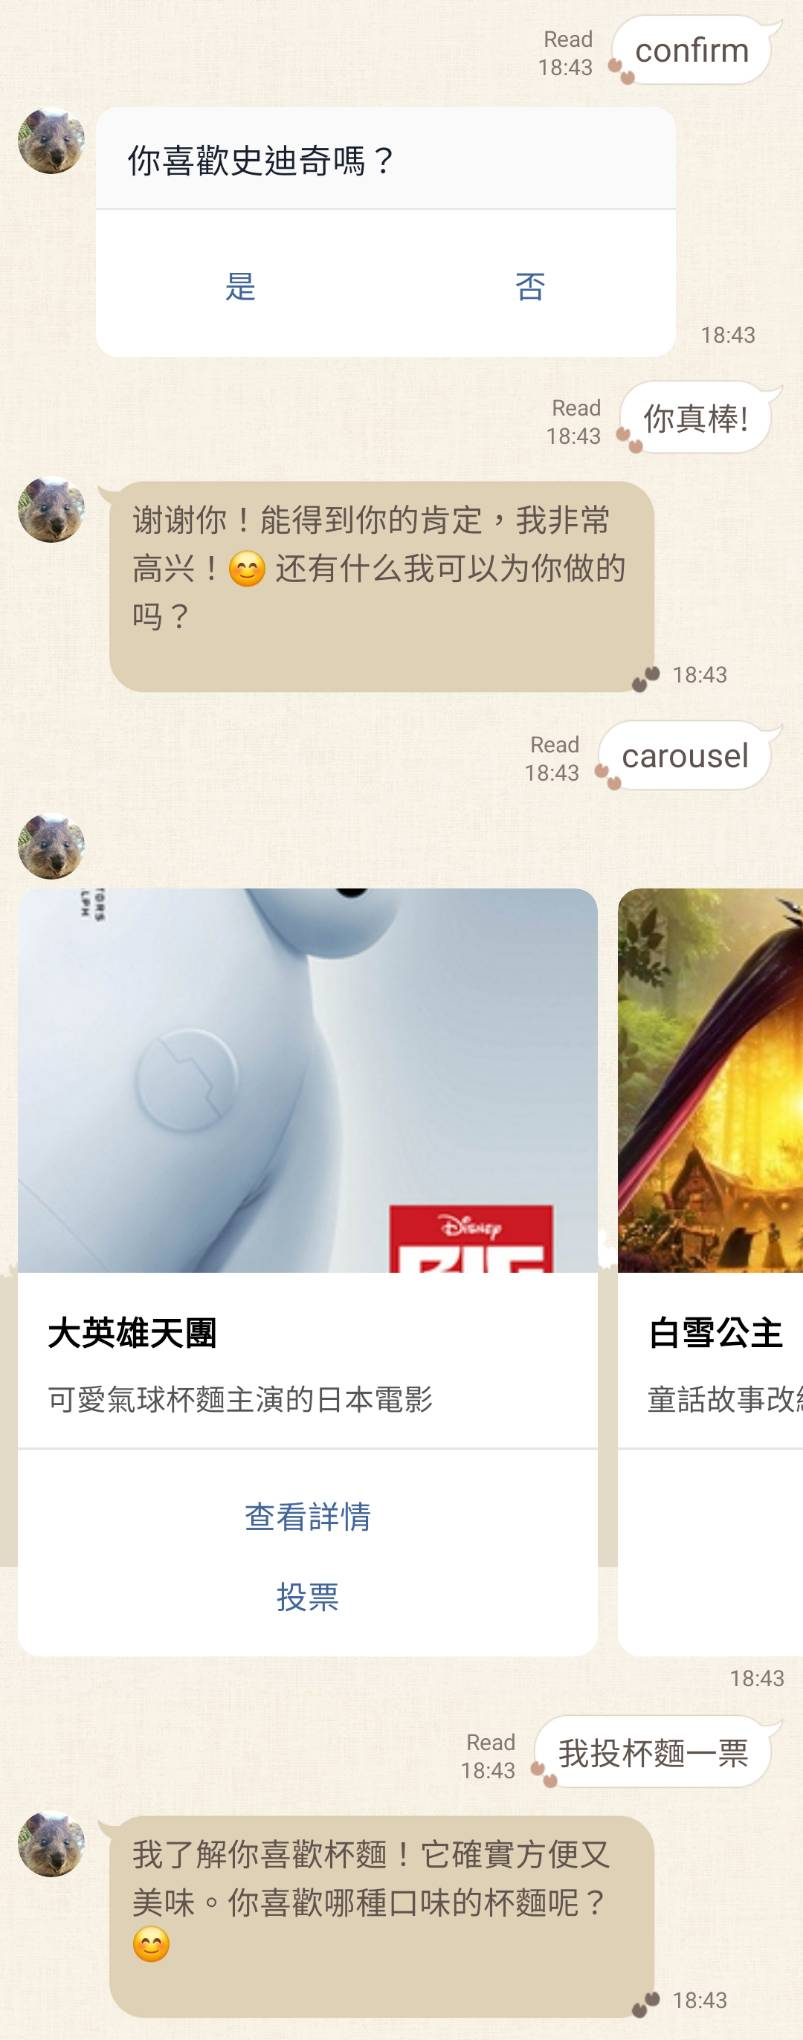

- Confirm Template

 - 使用者於 LINE 傳送訊息：「confirm」
 - LINE Bot 觸發 TemplateMessage，回應：「你喜歡史迪奇嗎？」並出現「是」或「否」選項
 - 使用者按下「是」選項
 - LINE Bot 觸發回應：「你真棒!」
 - Bot 回應由 Gemini 生成的內容：「谢谢你！能得到你的肯定，我非常高兴！😊 还有什么我可以为你做的吗？」

- Carousel Template
 - 使用者於 LINE 傳送訊息：「carousel」
 - LINE Bot 觸發 CarouselTemplate，回應圖片及「查看詳情」、「投票」選項
 - 使用者按下大英雄天團的「投票」選項，觸發回應：「我投杯麵一票」
 - Bot 回應由 Gemini 生成的內容：「我了解你喜歡杯麵！它確實方便又美味。你喜歡哪種口味的杯麵呢？😊」

### 效益分析

| 效益面向 | 具體說明 |
|----------|----------|
|技術可行性|	成功整合 Google Gemini API 與 LINE Messaging API，證明了在 LINE 平台上應用生成式 AI 的技術可行性|
|互動模式創新|	透過實現不同類型的 Reply Template Messages，本專案探索了在 LINE Bot 中提供豐富和結構化互動的可能性|
|使用者體驗基礎|	為使用者在熟悉的 LINE 介面中體驗生成式 AI 提供了基礎，潛在降低了使用門檻|
| 技術學習與掌握| 透過本專案，成功學習並掌握了 LINE Bot 開發、Google Gemini API 整合等相關技術|
| 整合開發能力展示 | 體現了整合不同 API 和服務的開發能力|



- 系統是否達到目標？  
是。系統成功讓使用者透過 LINE 與生成式 AI 互動，且 Gemini 回應具智慧與語意邏輯，符合預期成果。 Reply Template Messages 的應用也成功實現，提升了互動體驗。

## 未來發展與改進

### 改進建議  
- 增強對話連貫性： 引入上下文記憶功能，使 Bot 能理解前後對話關聯，提供更自然的交流體驗
- 擴展模板訊息應用： 因專案主題只以電影為主，希望能設計和實作更多樣化的 Reply Template Messages，不限於特定主題，以應對不同情境和需求
- 優化系統效能：持續優化程式碼及 API 調用流程，提高 Bot 回應速度，減少等待時間

### 未來規劃  
- 探索多模態能力： 研究整合 Gemini 的圖像生成等其他功能，豐富 Bot 的互動形式
- 開發多用途模板： 規劃並實作適用於不同領域和主題的 Reply Template Messages